# Remarques
* Three steps for cleaning probably provide better word2word meanings but since for us the main goal is to generate a coherent sentence from the input and meaning WE are feeding, then we can't leave out punctuation symbols and stop words. Maybe it is still good to lemmatize? We'll see

# Generating our descriptive sentences

## Importing everything we will need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import random
import string
import torch
import torch.nn as nn
#is this the best choice of autograd?
from torch.autograd import Variable 
import math
import time

## Getting out text input

In [47]:
#opening and reading the corpus
#we will be using the small version of the descriptive corpus we made
f = open('description-corpus-20k.txt', 'r')
#text = f.read()
text = f.readlines() #if we want a list with sentences as elements
f.close()

In [55]:
# getting lower case and splitting it
sentences = [text[i].lower().split() for i in range(len(text))]

In [101]:
#getting the avg length of a descriptive sentence
lengths = [len(sent) for sent in sentences]
avg_sent_length = sum(lengths)/len(lengths) # ~27

## Cleaning (NOT USED)
* Removing stop words, punctuation symbols and lemmatizing

In [3]:
# found that in some tutorials they do 3 extra cleaning steps before applying N-grams

# getting rid of stop words
#stop_words = set(nltk.corpus.stopwords.words('english'))
#stop_free = ' '.join([word for word in text.split() if word not in stop_words])
# justification --> it's like getting rid of the long tail in the word frequency plot. Oder?

# getting rid of punctuation
#punctuation_symbols = set(string.punctuation)
#punct_free = "".join(word for word in stop_free if word not in punctuation_symbols)
# makes sense.. I think

# lemmatizing?
#lemma = nltk.stem.wordnet.WordNetLemmatizer()
#normalized = ' '.join(lemma.lemmatize(word) for word in punct_free.split())
#if it is what I think it is, then it makes sense too

#last step, lower case and splitting
#cleaned_text = normalized.lower().split()

In [4]:
text[:250]

'A cookie is a text file that is placed on your hard disk by a Web page server .\nA listing is a product placed in the directory for sale .\nAfter all , a home is the largest ( and most emotional ) investment most people will ever make .\nWhile emotions '

In [5]:
stop_free[:250]

"A cookie text file placed hard disk Web page server . A listing product placed directory sale . After , home largest ( emotional ) investment people ever make . While emotions probably high gear 've found home love , 's important remember home invest"

In [6]:
punct_free[:250]

'A cookie text file placed hard disk Web page server  A listing product placed directory sale  After  home largest  emotional  investment people ever make  While emotions probably high gear ve found home love  s important remember home investment  Wit'

In [7]:
normalized[:250]

'A cookie text file placed hard disk Web page server A listing product placed directory sale After home largest emotional investment people ever make While emotion probably high gear ve found home love s important remember home investment With many qu'

## Only normalizing
* is it worth it having different tokens for cookie and cookies (in terms of having a correct sentence)?

## Implementing trigrams and setting up

In [49]:
#creating trigram sets EASY WAY
#trigrams = [([cleaned_text[i], cleaned_text[i+1]], cleaned_text[i+2])for i in range(len(cleaned_text) - 2)]

# this structure allows us to create context/target sets for each word. 

In [60]:
# better way: sentence by sentence, not the whole text in one go
trigrams = []
for sentence in sentences:
    trigrams += [([sentence[i], sentence[i+1]], sentence[i+2]) for i in range(len(sentence) - 2)]

In [9]:
trigrams[0]
#context for target word 'text' --> 'a' and 'cookie'

(['a', 'cookie'], 'text')

In [63]:
#to prototype we will only take 1000 trigrams out of the ~500000
trigrams=trigrams[:1000]

In [74]:
# getting set of words in vocab, it's length and the frequency of each word
voc = set()
for sentence in sentences:
    voc = voc.union(set(sentence))
voc_length = len(voc) #34174
word_to_freq = {word: i for i, word in enumerate(voc)}

In [78]:
#creating lists where we will store the input tensors
cont = []
tar = []
for context, target in trigrams:
    #creates a tensor with the frequency of both current context words
    context_freqs = torch.tensor([word_to_freq[word] for word in context], dtype = torch.long)
    #adds the tensor to inp
    cont.append(context_freqs)
    # does the same for the target and its frequency
    target_freq = torch.tensor([word_to_freq[target]], dtype = torch.long)
    tar.append(target_freq)

## Building the network 

In [82]:
#Cheking if we have access to training on GPU
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Fancy setup!')
else: 
    print('Too bad, training on CPU; dont exagerate with number of epochs.')

my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Too bad, training on CPU; dont exagerate with number of epochs.


In [83]:
class GRU(nn.Module):
    #init for input size, hidden size, output size and number of hidden layers.
    def __init__(self, input_s, hidden_s, output_s,n_layers = 1):
        super(GRU, self).__init__()
        self.input_s = input_s
        self.hidden_s = hidden_s
        self.output_s = output_s
        self.n_layers = n_layers
        # our encoder will be nn.Embedding
        # reminder: the encoder takes the input and outputs a feature tensor holding the information representing the input.
        self.encoder = nn.Embedding(input_s, hidden_s)
        #defining the GRU cell, still have to determine which parameters work best
        self.gru = nn.GRU(2*hidden_s, hidden_s, n_layers, batch_first=True, bidirectional=False)
        # defining linear decoder
        self.decoder = nn.Linear(hidden_s, output_s)
    
    def forward(self, input, hidden):
        #making sure that the input is a row vector
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_s))

In [84]:
def train(context, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for t in range(len(trigrams)):
        output, hidden = decoder(context[t], hidden)
        loss += criterion(output, target[t])
        
    loss.backward()
    decoder_optimizer.step()
    
    return loss.data.item() / len(trigrams)

In [85]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [86]:
n_epochs = 50
print_every = 10
plot_every = 10
hidden_s = 50
n_layers = 1
lr = 0.015

decoder = GRU(voc_length, hidden_s, voc_length, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
for epoch in range(1, n_epochs + 1):
    loss = train(cont,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 48s (10 10%) 4.8131]
 36s (20 20%) 3.3923]
 18s (30 30%) 2.0022]
 59s (40 40%) 1.0425]
 43s (50 50%) 0.5735]


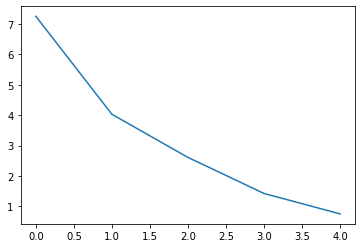

In [87]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [88]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_freq[w] for w in prime_str.split()], dtype=torch.long)
        cont = prime_input[-2:] #last two words as input
        output, hidden = decoder(cont, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_freq.keys())[list(word_to_freq.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [96]:
print(evaluate('the main word is', 10, temperature = 1))

the main word is a powerful engine


## Generating descriptive sentence
* input = main word + taboo words

The main idea here is that we will seed always with the main word and replace at the end.
The descriptive sentence will be accepted into the cleaning step (where we will make sure that no tws or the mw were used and if so, we'll replace them) if it contains at least two of the input words, besides the seeds. As long as the sentence is not accepted, we will keep generating.

To help reach a high score: once an input word has been used and its score_vector value increases, we will leave that segment in our sentence. Not sure if this hurts more than it helps, but adding the input word as a seed is VERY complicated. And not sure it would make sense either.

For a first prototype we will assume that maximum one new word is gonna be added per iteration. 

Pretty fragile with many assumptions?

It would be useful to generate a list of synonyms of all input words to expand the input_words set and have higher acceptance rate. We thought about cleaning the input words set from the start but those are words with high probability of occurence so we better leave them and clean in the end.

* maybe more seeds?
* maybe require a higher score?
* how to properly connect end of sentences and seeds? Is it better to have fewer seeds but longer auto-generated text?
* add time it to report results and "quantify" results/improvements

### 3 seeds (means, is, refers to). i=50
Final score: 

In [134]:
# set of words that we hope will appear in the description
input_words = np.array(['happy', 'pleased', 'thrilled', 'excited', 'ecstatic', 'overjoyed', 'joy'])
#extend!
#probably good idea to check if those words are even in our vocab. jeje
# filtering out the ones that are not. Shouldn't be a thing when using larger corpus
input_words = [word for word in input_words if word in voc]

#create the first sentence
#on average a descriptive sentence had 27 words/symbols.
# we will equally divide them between our seeds

sentence = evaluate('happy means', 9, temperature = 1) +' ' + evaluate('happy is', 9, temperature = 1) +' '+ evaluate('happy refers to', 9, temperature = 1)

eval_sentence = np.array(sentence.split())
# first score vector and score
score_vector = np.array([len(np.where(eval_sentence == input_words[i])[0]) for i in range(len(input_words))])
score = np.sum(score_vector) - 3 #to account for seeds

In [138]:
# iterate until nice sentence comes up
# we will add safety measure to not break everything
i = 0
n = 10
index_in_sentence = -1
# to keep track of scores
scores = np.zeros(n)
# the covered vector will take care that we don't replace a segment that we already "like"
covered = [0,0,0]
changes = np.zeros(len(score_vector))

#known positions of input words in our sentence
positions = np.zeros(len(eval_sentence))
#we know the positions of the seeds
positions[0] = 1
positions[9] = 1
positions[18] = 1

while i < n:
    #aware that with this flow we are doing one iteration after reaching the desired score, but it's no big deal because score is designed to only go up.
    
    #checking if score improved
    new_score_vector = np.array([len(np.where(eval_sentence == input_words[i])[0]) for i in range(len(input_words))])
    changes = new_score_vector - score_vector
    if changes != np.zeros(len(score_vector)): #there was a change. Assuming there is max 1 change per iteration from now on
        index = np.where(changes != 0)[0][0] #looking for the word that was added
        word_that_was_added = input_words[index] #if we stop assuming that, here we have to keep track of location and magnitude of changes
        #finding in which segment that new added word is in order to leave the segment untouched
        
        #how to detect the index of the word that just came up if it was already in the sentence somewhere else?
        #this should do
        indices_in_sentence = np.where(eval_sentence == word_that_was_added)[0]
        if len(indices_in_sentence) >0:
            for i in indices_in_sentence:
                if positions[i] != 1:
                    index_in_sentence = i
                    positions[i] = 1

        #keeping the segment in which the improvement took place
        if index_in_sentence in range(9) && covered[0]!=1:
            sentence = ' '.join(eval_sentence[:9]) +' '+ evaluate('happy is', 7, temperature = 1) +' '+ evaluate('happy refers to', 6, temperature = 1)
            covered[0] = 1
        elif index_in_sentence in range(9, 18) && covered[1] !=1:
            sentence = evaluate('happy means', 7, temperature = 1) +' ' + ' '.join(eval_sentence[9:18]) +' '+ evaluate('happy refers to', 6, temperature = 1)
            covered[1] = 1
        elif index_in_sentence in range(18, 27) && covered[2] != 1:
            sentence = evaluate('happy means', 7, temperature = 1) +' ' + evaluate('happy is', 7, temperature = 1) +' ' + ' '.join(eval_sentence[18:27])
            covered[2] = 1
        changes = np.zeros(len(score_vector))
        index_in_sentence = 0
        score_vector = new_score_vector
        score = np.sum(score_vector) - 3 #to account for seeds
    
    #if there was no change
    else:
        if covered == [0,0,0]: #score is still at 0
            sentence = evaluate('happy means', 7, temperature = 1) +' ' + evaluate('happy is', 7, temperature = 1) +' '+ evaluate('happy refers to', 6, temperature = 1)
            eval_sentence = np.array(sentence.split())
            score_vector = new_score_vector
            score = np.sum(score_vector) - 3 #to account for seeds
        #based on what is already covered
        #MAKE FUNCTION TO FACILITATE THIS!!
        
        elif covered == [1,0,0]:
            
    
    scores[i] = score
    i +=1

In [139]:
scores

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])